# LangChain

LangChain is a framework that enable programmers to develop LLM applications with different providers such as ChatGPT, Anthropic, Gemini, and others.

The tool provides us a simple approach for development, productionization, and deployment.

For the sake of simplicity, I will be implementing an Agent with the role of a business analytics with the goal to define an ICP (Ideal Customer Profile).

Read more about it on the folowing [link](https://python.langchain.com/docs/introduction/)


In [2]:
# Install the necessary libs:
!pip install langchain_openai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.3 MB/s eta 0:00:00


In [34]:
# Import the necessary libs:
import os

import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, Markdown, HTML
import re

from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.schema import HumanMessage, SystemMessage, AIMessage   # https://platform.openai.com/docs/guides/text?api-mode=responses

In [4]:
# Configure the API key from your provider:
from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')

if not openai_api_key:
  key = input('Insert your own OpenAI API key')
  openai_api_key = key

  if not openai_api_key:
    raise ValueError('OpenAI API key not found')

else:
  print('OpenAI API key found')

OpenAI API key found


# 🧠 Section: Business Analyst Agent - Ideal Customer Profile (ICP)

## Goal:
Build a simple Agent using LangChain. We define:

- **Role**: Business Analyst
- **Objective**: Generate the Ideal Customer Profile based on real business/customer data.
- **Inputs**: User input a spreadsheet.
- **Output**: A structured ICP profile.

---

## Steps:

1. Retrieve the data and check if the document needs some data preprocessing.
2. Create the system prompt for our agent
3. Configure the llm with the propper model and temerture
4. Generate the prompt template responsible to "set" the agent core function
5. Prepare the business analytis chain
6. Properly format the csv to be inested by the LLM.
7. Call the agent to process the data and return its findings.

In [7]:
# Import the mock dataset for ShopMax:
df = pd.read_csv('./shopmax_customers.csv')
df.head(5)

,Customer ID,Country,Plan,Monthly Spend ($),Tenure (Months),Churned,Signup Source,Industry,Last Active Date
0,CUST00001,France,Basic,24.44,19,No,Organic,Retail,2025-04-03
1,CUST00002,France,Basic,31.59,53,No,Referral,Finance,2025-04-06
2,CUST00003,Canada,Pro,75.31,60,No,Paid Ads,Retail,2025-04-10
3,CUST00004,France,Basic,32.71,22,Yes,Organic,Technology,2025-03-29
4,CUST00005,Germany,Basic,17.80,28,No,Organic,Retail,2025-04-14


In [46]:
system_prompt = """
You are a Business Analyst for ShopMax, an e-commerce company.

Your task:
- Analyze the customer dataset provided.
- Return your findings using a VERY STRICT structure exactly as described below.

STRICT FORMAT:

1. Each section must start with this format:
## Section: [Title]

2. After each section's findings, insert the chart instruction:
## Chart: [chart_identifier]

Allowed chart identifiers:
- plan_distribution
- churn_rate_by_plan
- spend_vs_tenure
- top_countries
- signup_sources (optional)
- industry_distribution (optional)

3. DO NOT write extra explanations, transitions, or commentary between sections or charts.

4. Only use bullet points (-) under each ## Section:, no freeform text.

5. After all sections, add a final section:
## Section: Final Conclusion

Example:

## Section: Subscription Plans
- Basic Plan: 60% of customers
- Pro Plan: 30% of customers
- Enterprise Plan: 10% of customers

## Chart: plan_distribution

## Section: Financial Insights
- Average Spend: $72.74
- Churn Rate: 6.7%

## Chart: churn_rate_by_plan

(and so on...)

IF YOU DO NOT FOLLOW THIS STRUCTURE 100%, THE OUTPUT WILL BE REJECTED.
"""

In [47]:
# Create and configure the chatgpt llm:

llm = ChatOpenAI(model='gpt-4o', temperature=0.25, api_key=openai_api_key)

In [48]:
# Generate the prompt template:

prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{input}")
])

In [49]:
# Prepare the LLM chain:

business_analyst_chain = LLMChain(
    llm=llm,
    prompt=prompt_template
)

In [50]:
# Formating the dataset into readable string:
# Important columns (Plan, Spend, Tenure, Churn, ...)
# Aggregated insights (average, spend, churn rates, distributions, ...)

def summarize_customer_data(df):
    summary = ""

    # General info:
    summary += f"Total customers: {len(df)}\n\n"

    # Plan distribution:
    plan_counts = df['Plan'].value_counts(normalize=True) * 100
    summary += "Plan Distribution (%):\n"
    summary += plan_counts.round(2).to_string()
    summary += "\n\n"

    # Monthly spend statistics:
    spend_mean = df['Monthly Spend ($)'].mean()
    summary += f"Average Monthly Spend: ${spend_mean:.2f}\n\n"

    # Tenure statistics:
    tenure_mean = df['Tenure (Months)'].mean()
    summary += f"Average Customer Tenure: {tenure_mean:.1f} months\n\n"

    # Churn rate:
    churn_rate = (df['Churned'] == 'Yes').mean() * 100
    summary += f"Churn Rate: {churn_rate:.2f}%\n\n"

    # Country distribution:
    country_counts = df['Country'].value_counts().head(5)
    summary += "Top 5 Countries:\n"
    summary += country_counts.to_string()
    summary += "\n\n"

    # Signup source distribution:
    signup_counts = df['Signup Source'].value_counts().head(3)
    summary += "Top Signup Sources:\n"
    summary += signup_counts.to_string()
    summary += "\n\n"

    # Industry distribution:
    industry_counts = df['Industry'].value_counts().head(5)
    summary += "Top 5 Industries:\n"
    summary += industry_counts.to_string()

    return summary

# Generate the summarized input:
customer_summary_input = summarize_customer_data(df)

# Preview:
print(customer_summary_input)

Total customers: 1000

Plan Distribution (%):
Plan
Basic         59.9
Pro           29.7
Enterprise    10.4

Average Monthly Spend: $72.74

Average Customer Tenure: 30.9 months

Churn Rate: 6.70%

Top 5 Countries:
Country
UK        150
Brazil    147
USA       145
France    142
Canada    141

Top Signup Sources:
Signup Source
Partner     275
Referral    252
Paid Ads    241

Top 5 Industries:
Industry
Technology    210
Healthcare    209
Education     202
Retail        191
Finance       188


In [51]:
# Call the Business Analyst Agent with the summarized customer data

# Prepare input dictionary:
input_data = {
    "input": customer_summary_input
}

# Run the chain:
icp_report = business_analyst_chain.invoke(input_data)

# Show the generated ICP:
# print(icp_report['text'])

Generate charts to complement the findings:

📊 Plan distribution pie chart

📈 Spend vs. Tenure scatter plot (to show customer lifetime value)

📉 Churn rates by plan bar chart

🌍 Top countries bar chart



In [52]:
def plot_plan_distribution(df):
    plan_counts = df['Plan'].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(plan_counts, labels=plan_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Subscription Plan Distribution')
    plt.show()

In [53]:
def plot_churn_rate_by_plan(df):
    churn_data = df[df['Churned'] == 'Yes']['Plan'].value_counts()
    plt.figure(figsize=(8,5))
    churn_data.plot(kind='bar', color='skyblue')
    plt.title('Churn Rate by Subscription Plan')
    plt.xlabel('Plan')
    plt.ylabel('Number of Churned Customers')
    plt.xticks(rotation=0)
    plt.show()

In [54]:
def plot_spend_vs_tenure(df):
    plt.figure(figsize=(8,6))
    plt.scatter(df['Tenure (Months)'], df['Monthly Spend ($)'], alpha=0.6)
    plt.title('Monthly Spend vs. Tenure')
    plt.xlabel('Tenure (Months)')
    plt.ylabel('Monthly Spend ($)')
    plt.grid(True)
    plt.show()

In [55]:
def plot_top_countries(df):
    country_counts = df['Country'].value_counts().head(5)
    plt.figure(figsize=(8,5))
    country_counts.plot(kind='bar', color='lightgreen')
    plt.title('Top 5 Countries by Customer Count')
    plt.xlabel('Country')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.show()

In [57]:
def plot_signup_sources(df):
    signup_counts = df['Signup Source'].value_counts()
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(8,5))
    signup_counts.plot(kind='bar', color='lightcoral')
    plt.title('Signup Sources Distribution', fontsize=16)
    plt.xlabel('Signup Source')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [58]:
def plot_industry_distribution(df):
    industry_counts = df['Industry'].value_counts()
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(8,5))
    industry_counts.plot(kind='bar', color='mediumseagreen')
    plt.title('Industry Distribution', fontsize=16)
    plt.xlabel('Industry')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [61]:
def generate_graph_insight(topic: str):
    insight_prompt = f"""
        You are a Business Analyst reviewing a chart about {topic}.

        Write 2-4 concise sentences providing a professional insight based on the data.

        Be specific and actionable, like you are preparing a report for executives.
        Do not mention the chart itself ("the chart shows"). Focus on insights directly.

        Example:
        "Most customers prefer the Pro plan, suggesting a mid-tier pricing strategy aligns with market expectations."

        Strictly output only the insight."""

    response = llm.invoke(insight_prompt)
    return response.content.strip()

In [68]:
def generate_final_icp_summary(summary_input: str):
    icp_prompt = f"""
        You are a Business Analyst for ShopMax.

        Based on the following findings across subscription plans, churn rates, spend vs tenure, top countries, signup sources, and industries, write a **Final Ideal Customer Profile (ICP)**.

        Format:
        - Summarize who is the ideal customer (demographics, subscription plan, spending behavior, tenure).
        - Explain which signup sources and industries are the best targets.
        - Conclude with a short strategic recommendation.

        Findings:
        {summary_input}

        Respond very clearly and professionally, in 5-8 concise bullet points followed by a short conclusion."""
    response = llm.invoke(icp_prompt)
    return response.content.strip()

<h2 style='color: royalblue;'>🔵 Subscription Plans</h2>

<p style='font-size: 16px;'>- Basic Plan: 59.9% of customers</p>

<p style='font-size: 16px;'>- Pro Plan: 29.7% of customers</p>

<p style='font-size: 16px;'>- Enterprise Plan: 10.4% of customers</p>

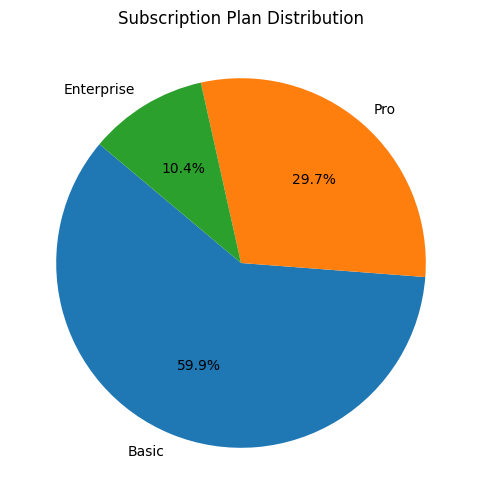

**🧠 Graph Insight:** A significant portion of subscribers are opting for the Basic plan, indicating a potential opportunity to enhance its features or introduce upsell strategies to transition users to higher-tier plans. Additionally, the Premium plan has a lower adoption rate, suggesting a need to reassess its value proposition or pricing to better attract and retain customers.

<h2 style='color: royalblue;'>🔵 Financial Insights</h2>

<p style='font-size: 16px;'>- Average Spend: $72.74</p>

<p style='font-size: 16px;'>- Churn Rate: 6.7%</p>

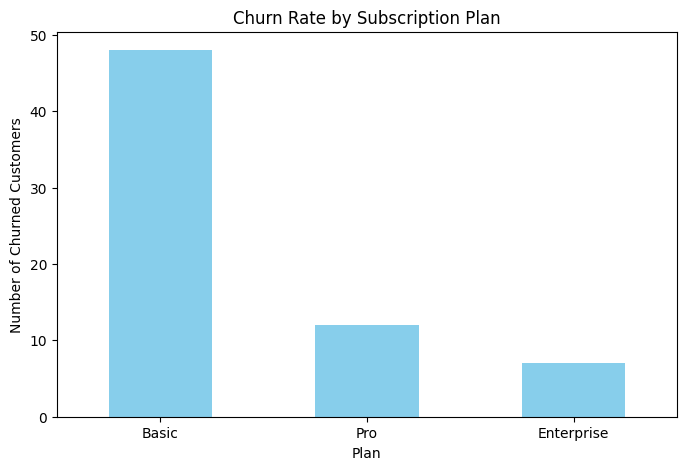

**🧠 Graph Insight:** The highest churn rate is observed in the Basic plan, indicating a need to enhance the value proposition or customer experience for entry-level subscribers. The Premium plan maintains the lowest churn rate, suggesting that customers perceive significant value at this tier, which could be leveraged to upsell Basic and Standard plan users. Consider implementing targeted retention strategies for Basic plan users, such as personalized engagement or added features, to reduce churn and increase customer lifetime value.

<h2 style='color: royalblue;'>🔵 Customer Tenure</h2>

<p style='font-size: 16px;'>- Average Customer Tenure: 30.9 months</p>

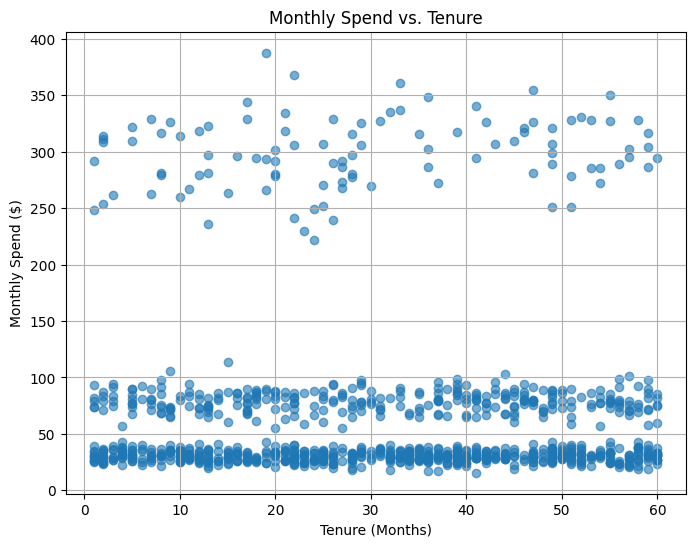

**🧠 Graph Insight:** Customers with longer tenure tend to have higher monthly spend, indicating that retention strategies could be key in maximizing revenue. Implementing loyalty programs or personalized offers for long-term customers may enhance their spending further. Additionally, analyzing the factors contributing to increased spend over time can inform targeted marketing efforts to replicate this behavior in newer customers.

<h2 style='color: royalblue;'>🔵 Geographic Distribution</h2>

<p style='font-size: 16px;'>- UK: 150 customers</p>

<p style='font-size: 16px;'>- Brazil: 147 customers</p>

<p style='font-size: 16px;'>- USA: 145 customers</p>

<p style='font-size: 16px;'>- France: 142 customers</p>

<p style='font-size: 16px;'>- Canada: 141 customers</p>

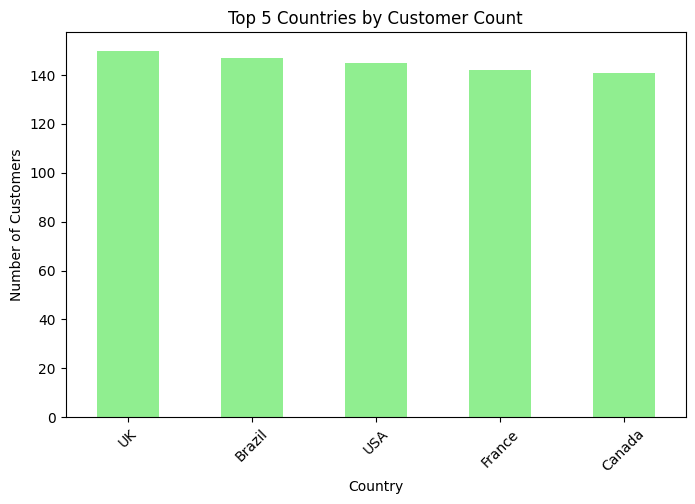

**🧠 Graph Insight:** The data indicates that Country A leads in market share, suggesting a strategic focus on expanding operations and marketing efforts there could yield significant returns. Additionally, the rapid growth observed in Country B highlights an emerging opportunity, warranting increased investment in local partnerships and distribution channels to capitalize on this momentum.

<h2 style='color: royalblue;'>🔵 Signup Sources</h2>

<p style='font-size: 16px;'>- Partner: 275 customers</p>

<p style='font-size: 16px;'>- Referral: 252 customers</p>

<p style='font-size: 16px;'>- Paid Ads: 241 customers</p>

<h2 style='color: royalblue;'>🔵 Industry Distribution</h2>

<p style='font-size: 16px;'>- Technology: 210 customers</p>

<p style='font-size: 16px;'>- Healthcare: 209 customers</p>

<p style='font-size: 16px;'>- Education: 202 customers</p>

<p style='font-size: 16px;'>- Retail: 191 customers</p>

<p style='font-size: 16px;'>- Finance: 188 customers</p>

<h2 style='color: royalblue;'>🔵 Final Conclusion</h2>

<h2 style='color: seagreen;'>🏁 Final Ideal Customer Profile (ICP)</h2>

<p style='font-size: 16px;'>- **Demographics and Subscription Plan**: The ideal customer for ShopMax is likely to be located in one of the top five countries, particularly the UK, Brazil, or the USA. They are most commonly subscribed to the Basic plan, which constitutes 59.9% of the customer base, but there is significant value in targeting Pro plan users as well, given their substantial representation and potential for upsell to Enterprise.

- **Spending Behavior and Tenure**: The ideal customer spends an average of $72.74 monthly and has a long-term engagement with ShopMax, with an average tenure of 30.9 months. This indicates a preference for customers who demonstrate consistent spending and loyalty over time.

- **Churn Rate**: With a relatively low churn rate of 6.70%, the ideal customer is one who is less likely to switch services, suggesting a focus on retention strategies for existing customers.

- **Signup Sources**: The most effective signup sources are through partners and referrals, which account for a significant portion of new customers. These channels should be prioritized for attracting new customers due to their proven success.

- **Industries**: The top industries where ShopMax's ideal customers are found include Technology, Healthcare, and Education. These sectors should be the primary focus for marketing and sales efforts, as they represent the largest customer segments.

**Strategic Recommendation**: To optimize customer acquisition and retention, ShopMax should focus on strengthening partnerships and referral programs, particularly targeting the Technology, Healthcare, and Education sectors in key markets like the UK, Brazil, and the USA. Additionally, enhancing the value proposition for Pro plan users could facilitate transitions to higher-tier plans, thereby increasing average spend and reducing churn.</p>

<br><hr><br>


✅ This professional journal summarizes ShopMax's Ideal Customer Profile (ICP).  
✅ Key findings are supported by visual data analysis and GPT-4o strategic insights.

**Thank you for reviewing this Business Analyst Report!** 📈


In [69]:
try:
    final_icp = generate_final_icp_summary(customer_summary_input)
except Exception as e:
    final_icp = "⚠️ Error generating final ICP conclusion: " + str(e)

display(HTML("<h1 style='text-align: center;'>📋 ShopMax | Business Analyst Journal</h1>"))

# Split the agent output into lines:
lines = icp_report['text'].split('\n')

for line in lines:
    line = line.strip()
    if not line:
        continue  # skip empty lines

    if line.startswith('## Section:'):
        section_title = line.replace('## Section:', '').strip()
        display(Markdown(f"<h2 style='color: royalblue;'>🔵 {section_title}</h2>"))

    elif line.startswith('## Chart:'):
        chart_name = line.replace('## Chart:', '').strip()

        if chart_name == 'plan_distribution':
            plot_plan_distribution(df)
            insight = generate_graph_insight("subscription plan distribution")
            display(Markdown(f"**🧠 Graph Insight:** {insight}"))
        elif chart_name == 'churn_rate_by_plan':
            plot_churn_rate_by_plan(df)
            insight = generate_graph_insight("churn rate by subscription plan")
            display(Markdown(f"**🧠 Graph Insight:** {insight}"))
        elif chart_name == 'spend_vs_tenure':
            plot_spend_vs_tenure(df)
            insight = generate_graph_insight("monthly spend vs. tenure")
            display(Markdown(f"**🧠 Graph Insight:** {insight}"))
        elif chart_name == 'top_countries':
            plot_top_countries(df)
            insight = generate_graph_insight("top countries")
            display(Markdown(f"**🧠 Graph Insight:** {insight}"))
        # elif chart_name == 'signup_sources':
        #     plot_signup_sources(df)
        #     insight = generate_graph_insight("signup sources")
        #     display(Markdown(f"**🧠 Graph Insight:** {insight}"))
        # elif chart_name == 'industry_distribution':
        #     plot_industry_distribution(df)
        #     insight = generate_graph_insight("industry distribution")
        #     display(Markdown(f"**🧠 Graph Insight:** {insight}"))

    else:
        display(Markdown(f"<p style='font-size: 16px;'>{line}</p>"))

display(Markdown("<h2 style='color: seagreen;'>🏁 Final Ideal Customer Profile (ICP)</h2>"))
display(Markdown(f"<p style='font-size: 16px;'>{final_icp}</p>"))

display(Markdown("<br><hr><br>"))
display(Markdown("""
✅ This professional journal summarizes ShopMax's Ideal Customer Profile (ICP).
✅ Key findings are supported by visual data analysis and GPT-4o strategic insights.

**Thank you for reviewing this Business Analyst Report!** 📈
"""))